In [1]:
%matplotlib inline
import utils
import torch
import matplotlib.pyplot as plt
import numpy as np

input_images, target_masks = utils.load_data(max_area=120000)

target_masks = utils.make_agregated_masks(target_masks)

for x in [input_images, target_masks]:
    print(x.shape)
    print(x.min(), x.max())

100%|█████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 350.63it/s]


(81, 336, 512)
0 255
(81, 336, 512)
0.0 1.0


In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split
import random

class MakeDataset(Dataset):
    def __init__(self, input_images, target_masks, transform=None):
        self.input_images, self.target_masks = input_images, target_masks        
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return [image, mask]

# use same transform for train/val for this example
trans = transforms.Compose([transforms.ToTensor(),])
random.seed(1)
images_train, images_test, masks_train, masks_test = train_test_split(input_images, target_masks, test_size=18)
random.seed(None)
train_set = MakeDataset(images_train, masks_train, transform = trans)
val_set = MakeDataset(images_test, masks_test, transform = trans)


batch_size = 12

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

In [ ]:
from UNet import UNet
from torchsummary import summary

device = torch.device("cpu")

model = UNet(in_channels=1, out_channels=1)
model = model.to(device)

summary(model, input_size=(1, 272, 416), device='cpu')

In [ ]:
from collections import defaultdict
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

def train_model(model, optimizer, scheduler, num_epochs=25, device=torch.device('cuda')):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_performance = 1e10 #on garde les modèles qui font des bonnes performance à la fois sur test et train pour eviter le hazard sur la validation
    best_loss = 1e10
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 30)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':

                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_samples = 0

            for inputs, masks in dataloaders[phase]:
                inputs = inputs.to(device, dtype=torch.float)
                masks = masks.to(device, dtype=torch.float)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = utils.loss(outputs, masks)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                        train_loss = loss.detach().item()
                    else:
                        val_loss = loss.detach().item()
            print(f'{phase} loss: {loss}')
            if phase == 'train':
                scheduler.step()

            # deep copy the model
            if phase == 'val':
                model_performance = val_loss  + (val_loss- train_loss)**2 # critère pour améliorer la generalisation en évitant les coups de chance
                if model_performance < best_performance and val_loss<best_loss :
                    print(f"saving best model ({model_performance})")
                    best_performance = model_performance
                    best_loss = val_loss
                    best_perf = f'train: {train_loss:4f}, val: {val_loss}, performance: {model_performance}'
                    best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print(f'{time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_perf}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Observe that all parameters are being optimized
torch.cuda.empty_cache()
device = torch.device('cuda')

model = UNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("naive_unet_weights.pth"))
model = model.to(device)

In [ ]:
optimizer_ft = optim.Adam(model.parameters(), lr=1e-7)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=1000, gamma=0.1)
torch.autograd.set_detect_anomaly(True)
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=100)

In [ ]:
torch.save(model.state_dict(), "naive_unet_weight.pth")

# Observation des résultats

In [3]:
from UNet import UNet

device = torch.device('cuda')
model = UNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("naive_unet_weight.pth"))
model = model.to(device=device)

In [4]:
inputs, masks = next(iter(dataloaders['val']))
inputs = inputs.to(device,  dtype=torch.float)
outputs = model(inputs)

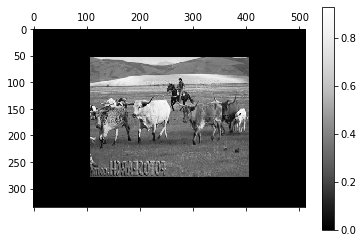

In [5]:
plt.matshow(inputs[2, 0].cpu(), cmap='Greys_r')
plt.colorbar()

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) tensor(0., device='cuda:0', grad_fn=<MinBackward1>)


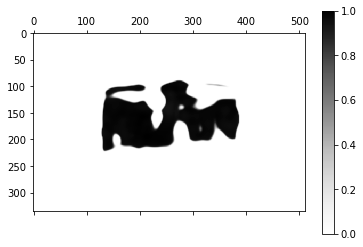

In [6]:
print(outputs.max(), outputs.min())
plt.matshow(outputs[2, 0].cpu().detach().numpy(), cmap='Greys')
plt.colorbar()

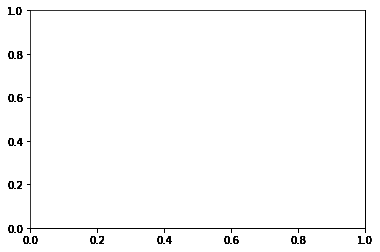

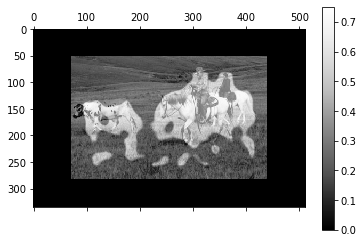

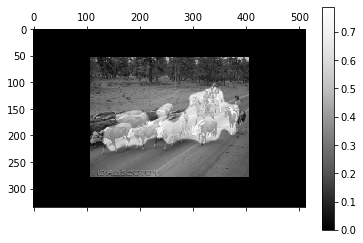

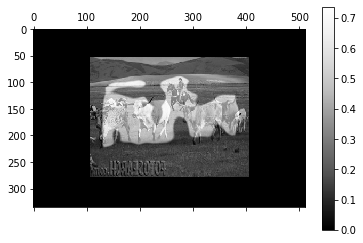

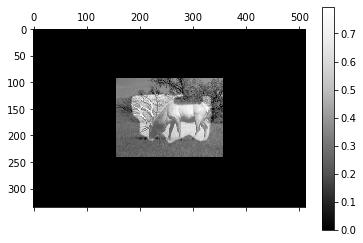

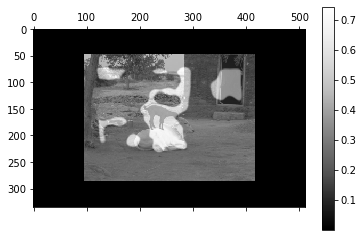

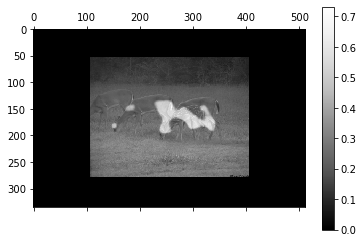

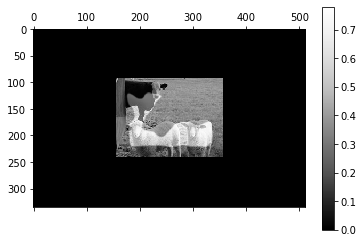

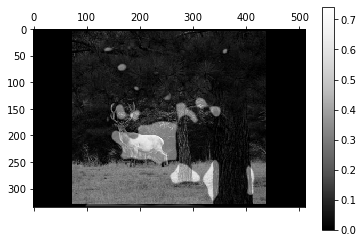

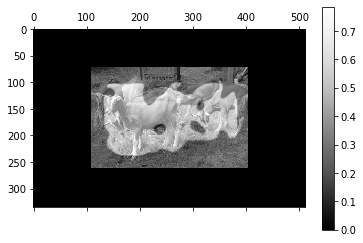

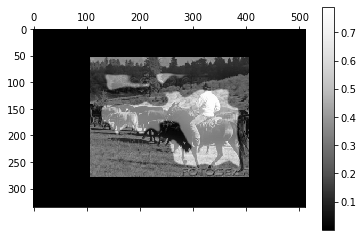

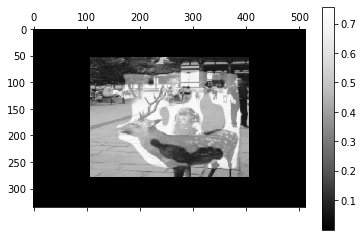

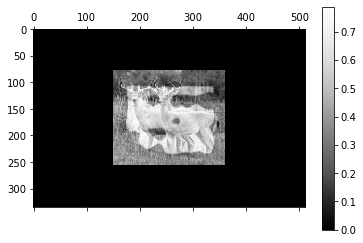

In [7]:
fig = plt.figure()
for i in range(batch_size):
    plt.matshow(0.3*outputs[i, 0].cpu().detach().numpy() + 0.5*inputs[i, 0].cpu().detach().numpy(), cmap='Greys_r')
    plt.colorbar()
    fig.add_subplot()